# Concept test
## VarClump1D

In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Helper functions

In [2]:
"""
Helper function to visualize the quality of the solution
"""
def compare_plot(c, sig, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

## Variational Model

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u_x(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|) = 0$$

whit boundary condition $u(\partial \Omega) = 0$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

In [3]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]

In [4]:
"""
Generating the data function
"""
f_data = data[:,300,300]
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='linear')
x_ = np.linspace(0., 1., 10*len(f_data), endpoint=True)

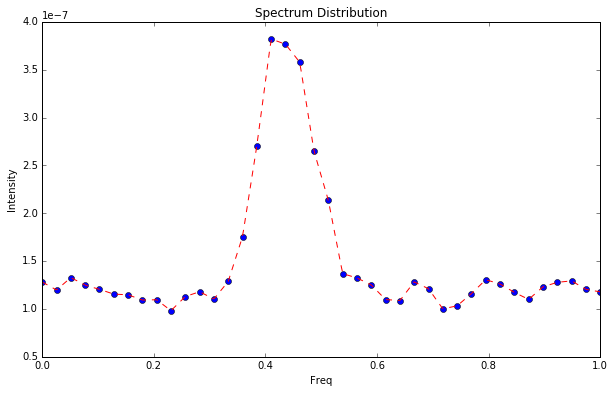

In [5]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, 'bo', x_, f(x_), 'r--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

$$\frac{4 (x-1) x+2}{4 (x-1)^2 x^2 \left(\cosh \left(\frac{1}{x}+\frac{1}{x-1}\right)+1\right)}$$

In [6]:
#setting parameters
a = 0.05
b = 0.1*0
N = 10

z = sym.Symbol('z')

#Penalizing function and its derivatives
#psi1 = sym.exp(z)
#d1psi1 = sym.diff(psi1, z)
#d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')
def d1psi1(x):
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('(4*(x-1)*x+2) / (4*(x-1)**2 * x**2 * (cosh(1/x + 1/(x-1))+1))')
    return ret
    

#Smoothing function and its derivatives
lamb = 0.5
#psi2 = 2*lamb*sym.log(1 + z**2/lamb)
psi2 = z**3
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

In [7]:
"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig):
    retval = ne.evaluate('exp(-x**2/(2*sig**2))')
    #retval = np.exp(-x**2/(2*sig**2))
    return retval

def phix(x, sig):
    retval = ne.evaluate('-(1./sig**2) * exp(-x**2/(2*sig**2)) * x')
    #retval = -(1./sig**2) * np.exp(-x**2/(2*sig**2)) * x
    return retval

def phixx(x, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-x**2/(2*sig**2)) * (x**2 - sig**2)')
    #retval = (1./sig**4) * np.exp(-x**2/(2*sig**2)) * (x**2 - sig**2)
    return retval

In [8]:
class ELFunc():
    def __init__(self, f0, c0, sig0, xc, Dx):
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        shape_Dx = Dx.shape
        #if len_c0 != len_sig0: 
        #    print('Dimensions of c0 and sig0 must match!')
        #    return None
        #if (shape_Dx[0]+2 != shape_Dx[1]) or (shape_Dx[1] != len_c0):
        #    print('Dimensions of Dx are wrong!')
        #    return None
        self.f0 = f0
        self.c = c0
        self.sig = sig0
        self.xc = xc
        self.Dx = Dx
        self.phi_m   = phi(Dx,sig0)
        self.phix_m  = phix(Dx,sig0)
        self.phixx_m = phixx(Dx,sig0)
    
    def set_c(self, c):
        self.c = c
    
    def set_sig(self, sig):
        self.sig = sig
        self.phi_m   = phi(self.Dx,sig)
        self.phix_m  = phix(self.Dx,sig)
        self.phixx_m = phixx(self.Dx,sig)
        
    """
    Function to optimize c parameters
    """
    def F1(self, c):
        #computing the Euler-Lagrange equation
        u   = np.dot(self.phi_m, c)
        ux  = np.dot(self.phix_m, c)
        uxx = np.dot(self.phixx_m, c)
        el  = 2.*(u-self.f0) + a*d1psi1(u-self.f0) - b*uxx*d2psi2(np.abs(ux))

        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,self.sig),c)-f_data[0], np.dot(phi(1.-self.xc,self.sig),c)-f_data[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        return np.concatenate([el,bc])

    """
    Function to optimize sig parameters
    """
    def F2(self, sig):    
        #phi function's evaluation
        phi_m   = phi(self.Dx, sig)
        phix_m  = phix(self.Dx, sig)
        phixx_m = phixx(self.Dx, sig)

        #computing the Euler-Lagrange equation
        u   = np.dot(phi_m, self.c)
        ux  = np.dot(phix_m, self.c)
        uxx = np.dot(phixx_m, self.c)
        el = 2.*(u-self.f0) + a*d1psi1(u-self.f0) - b*uxx*d2psi2(np.abs(ux))

        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,sig),self.c)-f_data[0], np.dot(phi(1.-self.xc,sig),self.c)-f_data[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        return np.concatenate([el,bc])
    
    """
    Function to optimize c and sig together
    """
    def F3(self, X):
        #unpacking parameters
        N = len(X)/2
        c = X[0:N]
        sig = X[N:]

        #phi function's evaluation
        phi_m   = phi(self.Dx, sig)
        phix_m  = phix(self.Dx, sig)
        phixx_m = phixx(self.Dx, sig)

        #computing the Euler-Lagrange equation
        u   = np.dot(phi_m, c)
        ux  = np.dot(phix_m, c)
        uxx = np.dot(phixx_m, c)
        el = 2.*(u-self.f0) + a*d1psi1(u-self.f0) - b*uxx*d2psi2(np.abs(ux))
        
        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,sig),c)-f_data[0], np.dot(phi(1.-self.xc,sig),c)-f_data[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        return np.concatenate([el,bc])

## Variating $c$ and $\sigma$ together

In [9]:
""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(xc)
print('----')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., 2*N, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe)
print('----')

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation points will be the same
"""
Dx = np.empty((2*N-2,N))
for k in range(N-2):
	Dx[k,:] = (xe[k] - xc)

Center points:
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
----
Evaluation points:
[ 0.05263158  0.10526316  0.15789474  0.21052632  0.26315789  0.31578947
  0.36842105  0.42105263  0.47368421  0.52631579  0.57894737  0.63157895
  0.68421053  0.73684211  0.78947368  0.84210526  0.89473684  0.94736842]
----


In [10]:
"""
Defining initial parameter values
"""
c0 = f(xc)/N
sig0 = (1./(N))*np.ones(N)

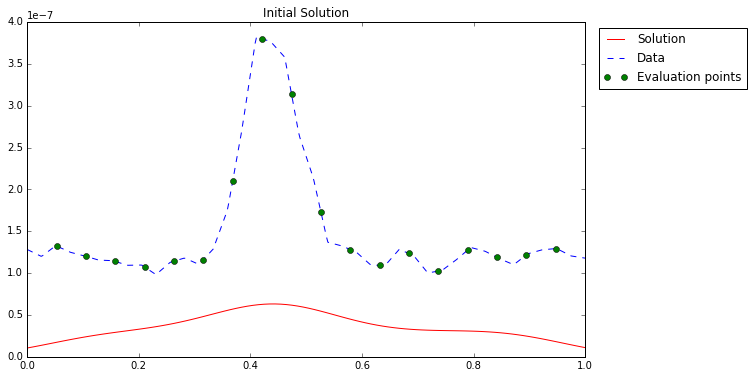

In [11]:
"""
Visualizing the 'initial' solution
"""
compare_plot(c0, sig0, title='Initial Solution')

In [12]:
"""
Instantiating the EL func object and solving it!
"""
elf = ELFunc(f0, c0, sig0, xc, Dx)
sol = sp.optimize.fsolve(elf.F3, np.concatenate([elf.c, elf.sig]))
opt_c = sol[0:N]
opt_sig = sol[N:]
print(opt_c)
print(opt_sig)

[ -9.64681608e-08   4.83469987e-07  -3.27661598e-07   2.08005473e-07
   7.42098358e-08  -5.95756694e-08   5.25216854e-08  -1.17252698e-07
  -1.90396877e-07   1.11614880e-07]
[  2.14133509e-01   8.18909419e-01   2.34151656e-01   3.08718234e-01
  -8.57069814e-02   1.12233521e-03   5.02455122e-01  -2.72931727e+01
   2.60776196e+01  -6.76373138e+01]


/home/martin/miniconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


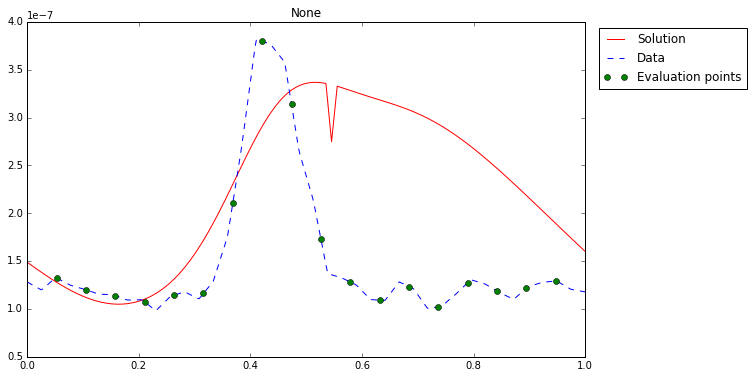

In [13]:
compare_plot(opt_c, opt_sig)

## Variating $c$ and $\sigma$ separately

In [19]:
""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(xc)
print('----')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., N, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe)
print('----')

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation points will be the same
"""
Dx = np.empty((N-2,N))
for k in range(N-2):
	Dx[k,:] = (xe[k] - xc)

Center points:
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
----
Evaluation points:
[ 0.11111111  0.22222222  0.33333333  0.44444444  0.55555556  0.66666667
  0.77777778  0.88888889]
----


In [20]:
"""
Defining initial parameter values
"""
c0 = f(xc)/N
sig0 = (1./(N))*np.ones(N)

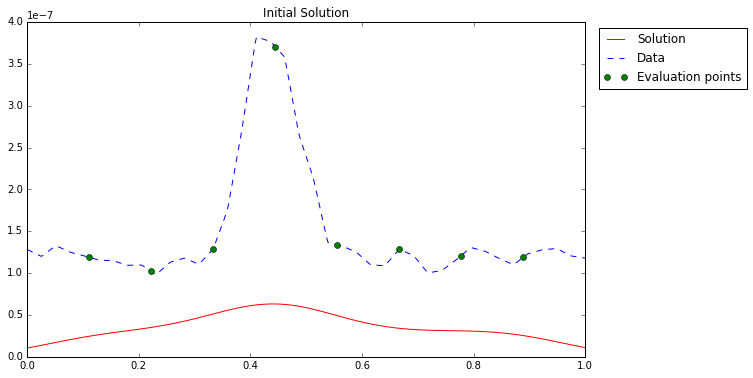

In [21]:
"""
Visualizing the 'initial' solution
"""
compare_plot(c0, sig0, title='Initial Solution')

In [17]:
"""
Instantiating the EL func object
"""
elf = ELFunc(f0, c0, sig0, xc, Dx)

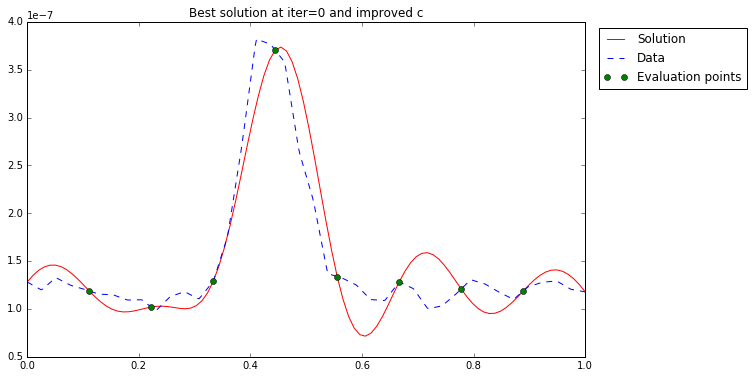

Variation on c=1.99911099211e-06
------------------------------------------------------------


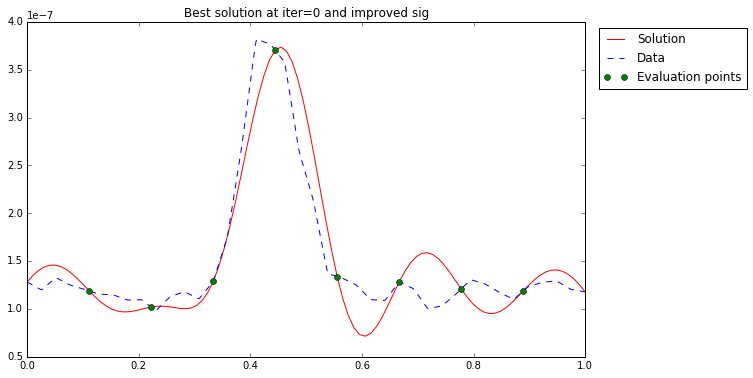

Variation on sig=4.48359946544e-15
-------------------------------------------------------------


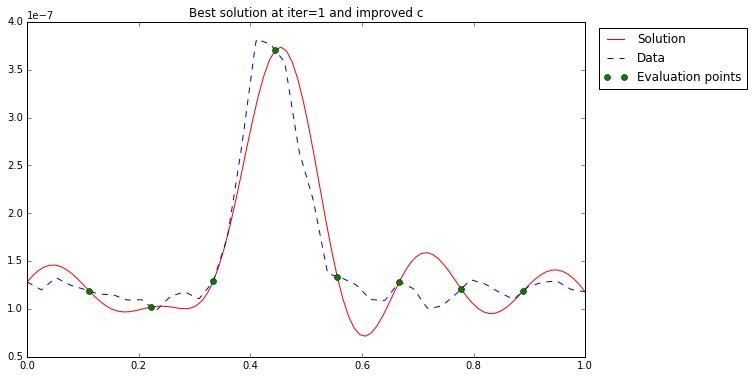

Variation on c=1.39513568048e-21
------------------------------------------------------------


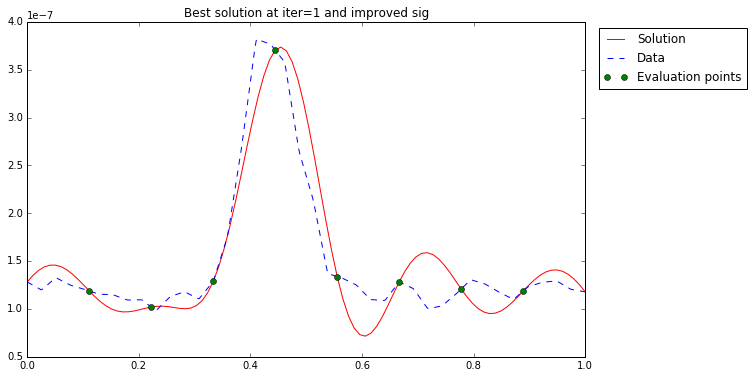

Variation on sig=0.0
-------------------------------------------------------------


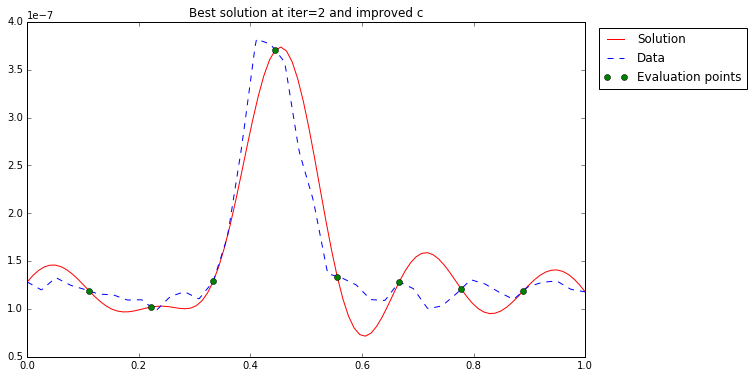

Variation on c=7.21028245123e-22
------------------------------------------------------------


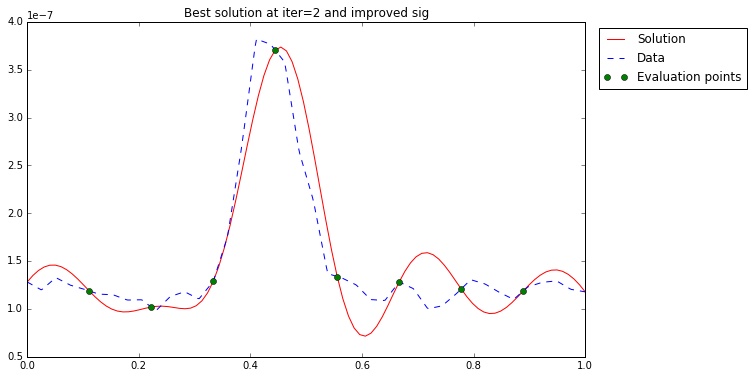

Variation on sig=0.0
-------------------------------------------------------------


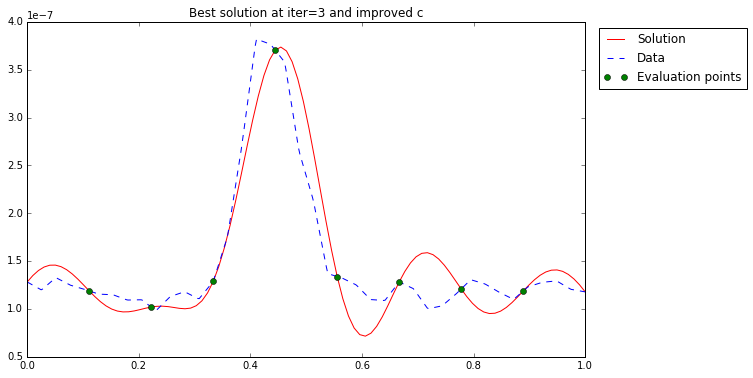

Variation on c=0.0
------------------------------------------------------------


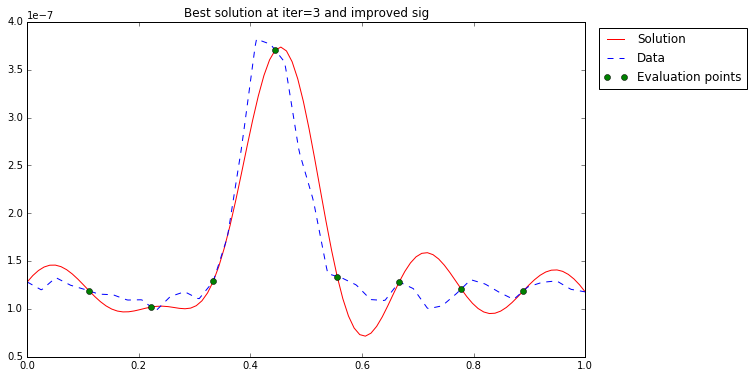

Variation on sig=0.0
-------------------------------------------------------------


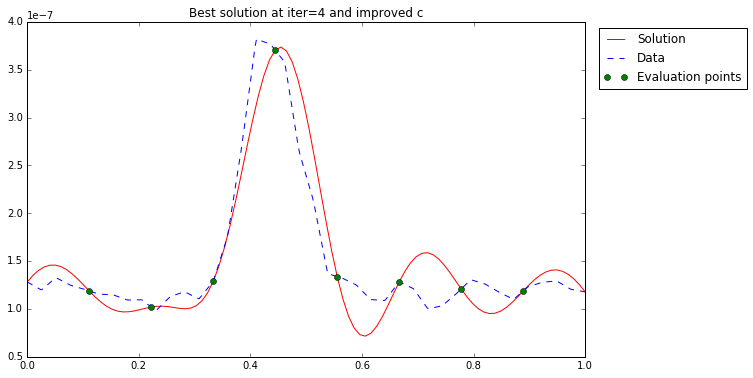

Variation on c=0.0
------------------------------------------------------------


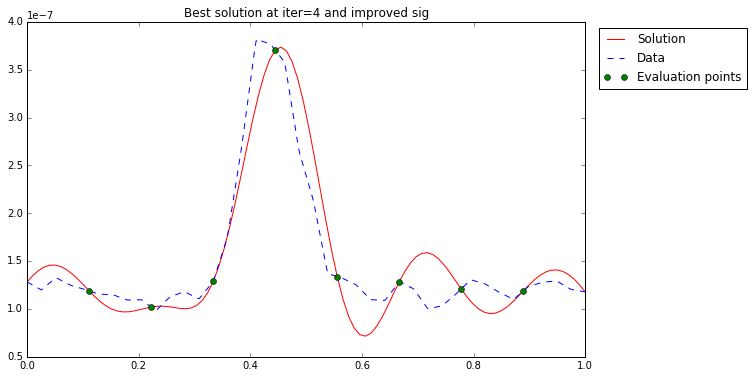

Variation on sig=0.0
-------------------------------------------------------------


In [18]:
"""
Solve it!
"""
n_iter = 5

for i in range(n_iter):
    #solve for c
    opt_c = sp.optimize.fsolve(elf.F1, elf.c)
    delta_c = np.linalg.norm(opt_c-elf.c)
    elf.set_c(opt_c)
    title = 'Best solution at iter={0} and improved c'.format(i)
    compare_plot(elf.c, elf.sig, title=title)
    print('Variation on c='+str(delta_c))
    print('------------------------------------------------------------')
    
    #solve for sig
    opt_sig = sp.optimize.fsolve(elf.F2, elf.sig)
    delta_sig = np.linalg.norm(opt_sig-elf.sig)
    elf.set_sig(opt_sig)
    title = 'Best solution at iter={0} and improved sig'.format(i)
    compare_plot(elf.c, elf.sig, title=title)
    print('Variation on sig='+str(delta_sig))
    print('-------------------------------------------------------------')

TODO (last season):
- try different bc
- study 2 gaussians case
- try solver: min |F|
- study well posedeness of the problem

IDEAS:
* Other methods for solving the ODE/PDE: FEM, Spectral Methods, ...
* Change evaluation points at each iteration
* Define good function $\Psi_1$ and $\Psi_2$